In [1]:
import sys
import pickle
import warnings
import matplotlib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import gridspec

sys.path.append('..')
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

In [2]:
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
matplotlib.rcParams["text.latex.preamble"] = [r"\usepackage{amsmath}"]

In [3]:
from data_processing.data import get_data, create_profiles, moment_match_theta_priors

In [4]:
from models.inference import Nowcaster
from models.utils import empirical_credint
from models.plotting import plot_posterior

## Data

#### Weekend effects in test counts

In [5]:
df = pd.read_csv(f"../data/cases-2020-12-30.csv")
df = df[(df["Area type"]=='ltla')&(df['Specimen date'] >= "2020-11-01") & (df['Specimen date'] <= '2020-11-30')]

In [6]:
df['Specimen date'] = pd.to_datetime(df['Specimen date'])
df['DoW'] = df['Specimen date'].dt.day_name()
df['weekend'] = 'Week-days'
df.loc[df['DoW'].isin(['Saturday', 'Sunday']), 'weekend'] = 'Weekend'

In [7]:
means = df.groupby('Area name')['Daily lab-confirmed cases'].mean()

In [8]:
high = means[means >=100].keys().to_list()
mid = means[(means < 100) & (means >= 20)].keys().to_list()
low = means[means < 20].keys().to_list()

In [9]:
df_high = df[df['Area name'].isin(high)]
df_mid = df[df['Area name'].isin(mid)]
df_low = df[df['Area name'].isin(low)]

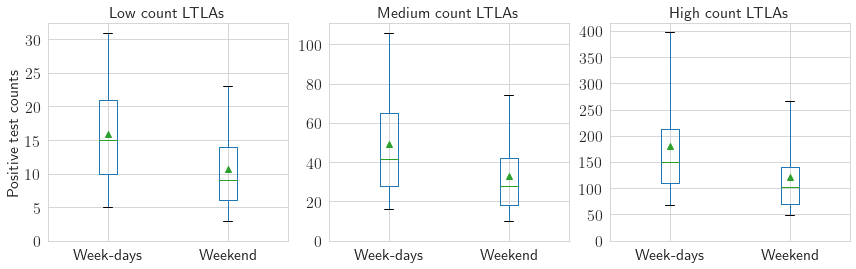

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# maxes = [35, 120, 400]

df_low.boxplot('Daily lab-confirmed cases', by='weekend', showfliers=False, showmeans=True, whis=(5,95), ax=ax[0])
df_mid.boxplot('Daily lab-confirmed cases', by='weekend', showfliers=False, showmeans=True, whis=(5,95), ax=ax[1])
df_high.boxplot('Daily lab-confirmed cases', by='weekend', showfliers=False, showmeans=True, whis=(5,95), ax=ax[2])

ax[0].set_title("Low count LTLAs", fontsize=16)
ax[1].set_title("Medium count LTLAs", fontsize=16)
ax[2].set_title("High count LTLAs", fontsize=16)

for i in range(3):
    ax[i].set_xlabel("")
    ax[i].set_ylim(0)
    plt.setp(ax[i].get_xticklabels(), fontsize=16)
    plt.setp(ax[i].get_yticklabels(), fontsize=16)

ax[0].set_ylabel("Positive test counts", fontsize=16)
plt.suptitle("")
plt.tight_layout()
plt.savefig("weekend_effects", dpi=100)

### Example report updates

In [11]:
df = get_data(
        "Leeds",
        report_dates=pd.date_range(start="2020-11-28", end="2020-12-30"),
        specimen_dates=pd.date_range(start="2020-11-27", end="2020-12-16"),
    )

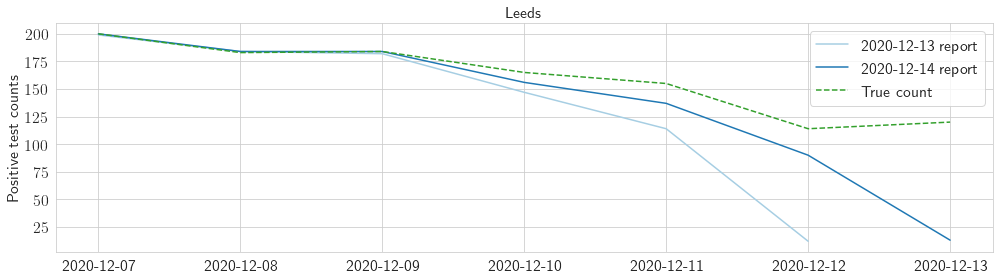

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))

t = pd.date_range(start="2020-12-07", end="2020-12-13").strftime("%Y-%m-%d")
    
colors = sns.color_palette("Paired").as_hex()    
for i, dt in enumerate(["2020-12-13", "2020-12-14"]):#, "2020-07-29"]):
    counts = df[(df['Report date']==dt)&(df['Specimen date'].isin(t))]['Daily lab-confirmed cases'].values
    ax.plot(counts, label=f"{dt} report", color=colors[i])
    
ax.plot(df[(df['Report date']=='2020-12-30')&(df['Specimen date'].isin(t))]['Daily lab-confirmed cases'].values, 
        label='True count', linestyle='--', color=colors[3])
    
ax.set_ylabel("Positive test counts" , fontsize=16)
plt.xticks(np.arange(0,len(t)),labels=t)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.legend(fontsize=16)
plt.title("Leeds", fontsize=16)
plt.tight_layout()
plt.savefig("example_reports", dpi=100)
plt.show()

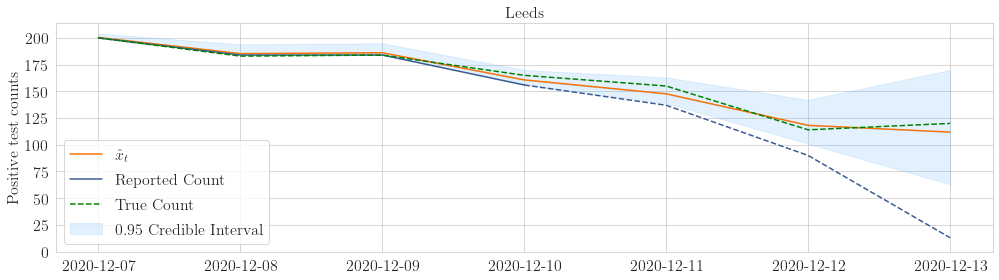

In [13]:
from models.utils import empirical_credint
from models.plotting import plot_posterior

final_df = pd.read_csv(f"../data/cases-2020-12-30.csv")


ltla='Leeds'
dt = '2020-12-14'

fig, ax = plt.subplots(figsize=(14, 4))
alpha = 0.05

start_idx = 11
sd_dates = pd.date_range(start="2020-11-26", end="2020-12-13").strftime("%Y-%m-%d")[start_idx:]

#TODO: fix path!!
with open(f'results/{dt}/{ltla}.pickle', 'rb') as f:
    model = pickle.load(f)

truth = final_df[
    (final_df['Area name']==ltla)&
    (final_df['Area type']=='ltla')&
    (final_df['Specimen date'] >= '2020-11-26')&
    (final_df['Specimen date']< dt)].sort_values("Specimen date")['Daily lab-confirmed cases'].values[start_idx:]

x_smoothing_means = np.array([s.mean() for s in model.x_smoothing_samples[start_idx:]])
x_smoothing_medians = np.array([np.median(s) for s in model.x_smoothing_samples[start_idx:]])
x_smoothing_cis = np.array(
    [empirical_credint(s, alpha) for s in model.x_smoothing_samples[start_idx:]]
)      


plot_posterior(
        ax=ax,
        obs=model._observations[start_idx:],
        posterior_means=x_smoothing_means,
        posterior_confidence_intervals=x_smoothing_cis,
        legend=True,
        posterior_label=r"$\hat x_t$",
        confidence_interval_label=f"{1-alpha} Credible Interval",
        obs_label="Reported Count",
    )
ax.plot(truth, "--", color='green', label='True Count')

ax.set_title(ltla, fontsize=16)
ax.legend(loc=3, fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)


ax.set_ylabel("Positive test counts", fontsize=16)
ax.set_ylim(0)

plt.xticks(np.arange(0,len(model._observations[start_idx:])),labels=sd_dates)

# ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=3))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.grid(which='minor')
    
# 
plt.setp(ax.xaxis.get_majorticklabels(), rotation=360)


# fig.text(-0.01, 0.5, 'Positive test counts', va='center', rotation='vertical', fontsize=16)
    
plt.tight_layout()
plt.savefig(f"example_{ltla}_nowcast", dpi=100)
plt.show()

### Example timeseries for $\theta$ 

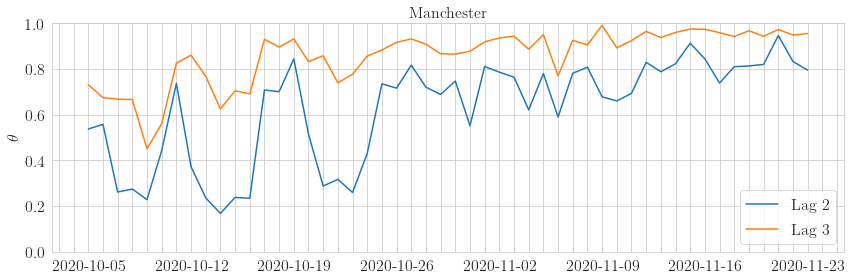

In [14]:
area = "Manchester"

fig, ax = plt.subplots(figsize=(12,4))

df = get_data(
    area,
    report_dates=pd.date_range(start="2020-10-06", end="2020-11-30"),
    specimen_dates=pd.date_range(start="2020-10-05", end="2020-11-29"),
)

lag2 = df[df['lag']==2]
lag3 = df[df['lag']==3]
# lag4 = df[df['lag']==4]

props2 = lag2['prop_reported'][:-4]
props3 = lag3['prop_reported'][:-4]
# props4 = lag4['prop_reported'][:-4]

ax.plot(lag2['Specimen date'][:-5], props2[:-1], label='Lag 2')
ax.plot(lag3['Specimen date'][:-4], props3, label='Lag 3')

ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=0))

ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
plt.grid(which='minor')

ax.set_ylim(0,1.0)
ax.set_title(area, fontsize=16)

plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)

ax.set_ylabel(r"$\theta$", fontsize=16)
    
ax.legend(fontsize=16)
plt.tight_layout()

plt.savefig("reporting_history", dpi=100)
plt.show()

## Empirical $\theta$ distributions

In [15]:
areas = ["Manchester", "Thurrock", "Hastings"]

data = pd.concat([get_data(
        area,
        area_type="ltla",
        report_dates=pd.date_range(start="2020-11-02", end="2021-01-05"),
        specimen_dates=pd.date_range(start="2020-11-01", end="2020-12-30"),
    ) for area in areas] + [get_data(
        'England',
        area_type="nation",
        report_dates=pd.date_range(start="2020-11-02", end="2021-01-05"),
        specimen_dates=pd.date_range(start="2020-11-01", end="2020-12-30"),
    )]
                )

data['DoW'] = pd.to_datetime(data["Specimen date"]).dt.weekday
data['DoW_name'] = pd.to_datetime(data["Specimen date"]).dt.day_name()

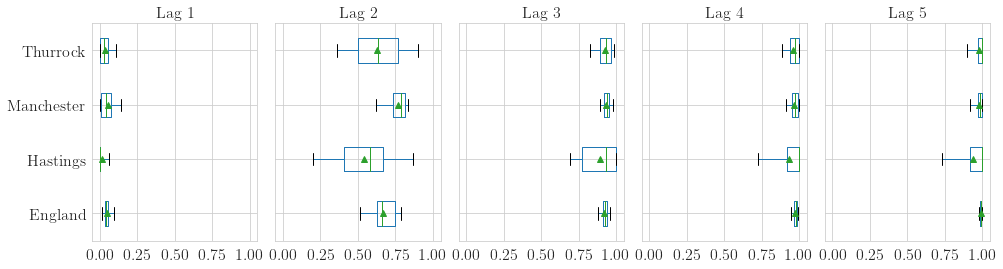

In [16]:
fig, ax = plt.subplots(1, 5, figsize=(14, 4), sharex=True)

areas = areas + ['England'] 

for i in range(5):
    curr_ax = ax[i]
    df = data[(data["lag"]==i+1)&(data['Area name'].isin(areas))&(data['Specimen date']<='2020-11-30')]
    bp = df.boxplot('prop_reported', by='Area name', 
                           showfliers=False, showmeans=True, ax=curr_ax, 
                            whis=(5,95), return_type="both", vert=False)


    if i != 0:
        curr_ax.set_ylabel("")
        curr_ax.set_yticklabels([])
    curr_ax.set_title(f"Lag {i+1}", fontsize=16)

    curr_ax.set_xlabel("")

    plt.setp(curr_ax.get_xticklabels(), fontsize=16)
    plt.setp(curr_ax.get_yticklabels(), fontsize=16)
    
plt.suptitle("")  
    
plt.tight_layout()

plt.savefig("thetas_november", dpi=100)
plt.show()

### Example beta priors

In [17]:
# column names
an, ac, at = 'Area name', 'Area code', 'Area type'
sd, dlcc, clcc = 'Specimen date', 'Daily lab-confirmed cases', 'Cumulative lab-confirmed cases'
rd = "Report date"
# field names
ltla, utla, region, nation = 'Lower tier local authority', 'Upper tier local authority', 'Region', 'Nation'


In [18]:
from scipy.stats import beta

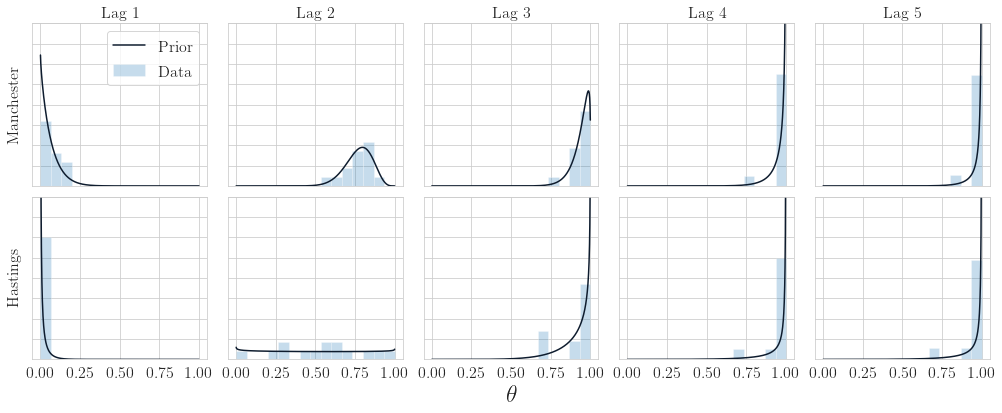

In [19]:
x = np.linspace(0, 1, 1002)[1:-1]

fig, ax = plt.subplots(2, 5, figsize=(14,6), sharex='col', sharey='row')

for n,l in enumerate(["Manchester", "Hastings"]):
      
    df = get_data(
        l,
        report_dates=pd.date_range(start="2020-11-06", end="2020-11-24"),
        specimen_dates=pd.date_range(start="2020-11-05", end="2020-11-23"),
    )
    
    mm_priors = moment_match_theta_priors(df)
    
    for i in range(5):
        curr_ax = ax[n,i]

        empirical = df[df['lag']==i+1][:-4]
        curr_ax.hist(empirical['prop_reported'], range=(0,1), bins=15, label='Data', alpha=0.25, density=True)

        dist = beta(mm_priors[0][-(i+1)], mm_priors[1][-(i+1)])
        curr_ax.plot(x, dist.pdf(x), label='Prior', color="#0e1c2e")
        
        curr_ax.set_ylim(0,20)
        
        if i == 0:
            curr_ax.set_ylabel(f"{l}", fontsize=16)
        curr_ax.set_yticklabels([])

        if n == 0:
            curr_ax.set_title(f"Lag {i+1}", fontsize=16)

        if n==1 and i==2:
            curr_ax.set_xlabel(r'$\theta$', fontsize=24)
            
        plt.setp(curr_ax.get_xticklabels(), fontsize=16)
        plt.setp(curr_ax.get_yticklabels(), fontsize=16)
        
        plt.setp(curr_ax.get_xticklabels(), fontsize=16)
        plt.setp(curr_ax.get_yticklabels(), fontsize=16)
        
ax[0,0].legend(fontsize=16)
plt.suptitle(f"", fontsize=16)
plt.tight_layout() 
plt.subplots_adjust(wspace=0.12)  
plt.savefig(f"example_priors", dpi=100)
plt.show()

## Now-cast examples

In [20]:
from models.plotting import plot_posterior
from models.utils import empirical_credint

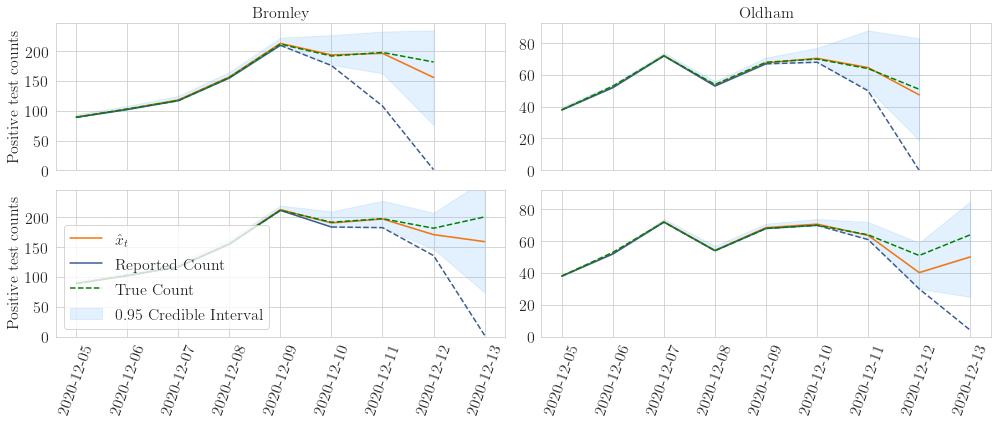

In [21]:
final_df = pd.read_csv(f"../data/cases-2020-12-19.csv")
ltlas = ["Bromley", "Oldham"]

fig, ax = plt.subplots(2, 2, figsize=(14, 6), sharex=True, sharey='col')
alpha = 0.05

start_idx = 10
sd_dates = pd.date_range(start="2020-11-25", end="2020-12-13").strftime("%Y-%m-%d")[start_idx:]


for i,ltla in enumerate(ltlas):
    for j, dt in enumerate(["2020-12-13", "2020-12-14"]):
        curr_ax = ax[j,i]
        with open(f'results/{dt}/{ltla.replace(" ", "_")}.pickle', 'rb') as f:
            model = pickle.load(f)

        truth = final_df[
            (final_df['Area name']==ltla)&
            (final_df['Area type']=='ltla')&
            (final_df['Specimen date'] >= '2020-11-25')&
            (final_df['Specimen date']< dt)].sort_values("Specimen date")['Daily lab-confirmed cases'].values[start_idx:]

        x_smoothing_means = np.array([s.mean() for s in model.x_smoothing_samples[start_idx-j:]])
        x_smoothing_medians = np.array([np.median(s) for s in model.x_smoothing_samples[start_idx-j:]])
        x_smoothing_cis = np.array(
            [empirical_credint(s, alpha) for s in model.x_smoothing_samples[start_idx-j:]]
        )      

        legend = True if i==1 and j==1 else False
        plot_posterior(
                ax=curr_ax,
                obs=model._observations[start_idx-j:],
                posterior_means=x_smoothing_means,
                posterior_confidence_intervals=x_smoothing_cis,
                legend=False,
                posterior_label=r"$\hat x_t$",
                confidence_interval_label=f"{1-alpha} Credible Interval",
                obs_label="Reported Count",
            )
        curr_ax.plot(truth, "--", color='green', label='True Count')
        if j==0:
            curr_ax.set_title(ltlas[i], fontsize=16)
        if i==0 and j==1:
            curr_ax.legend(loc=3, fontsize=16)
        plt.setp(curr_ax.get_xticklabels(), fontsize=16)
        plt.setp(curr_ax.get_yticklabels(), fontsize=16)
       
        if i == 0:
            curr_ax.set_ylabel("Positive test counts", fontsize=16)
        curr_ax.set_ylim(0)

plt.xticks(np.arange(0,len(model._observations[start_idx-1:])),labels=sd_dates)
    
for a in [ax[1,0], ax[1,1]]:   
    plt.setp(a.xaxis.get_majorticklabels(), rotation=70)
    
plt.tight_layout()
plt.savefig("example_nowcast", dpi=100)
plt.show()

#### Moving averages vs $\lambda$

In [22]:
def lwma(x, window=7):
    """Linearly weighted moving average"""
    weights = np.array([i for i in range(1,window+1)])
    return [sum(x[i:window+i]*weights)/sum(weights) for i in range(len(x)-window+1)]

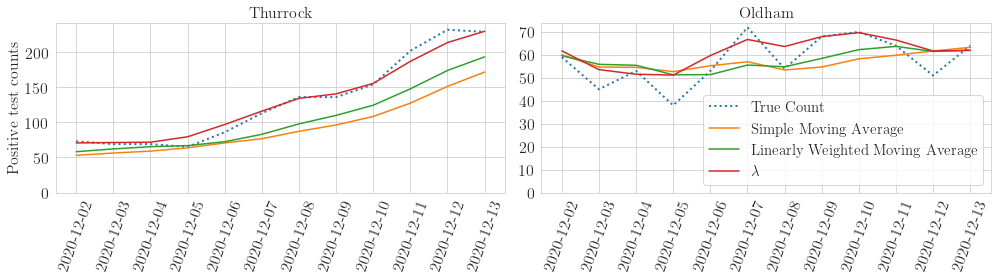

In [23]:
final_df = pd.read_csv("../data/cases-2020-12-30.csv")

colors = sns.color_palette().as_hex()

fig, ax = plt.subplots(1, 2, figsize=(14,4))

dt = "2020-12-14"

for i, ltla in enumerate(["Thurrock", "Oldham"]):
    with open(f'results/{dt}/{ltla}.pickle', 'rb') as f:
        model = pickle.load(f)
    results = pd.DataFrame({
    "data": model._observations, 
    "nowcast": [np.median(x) for x in model.x_smoothing_samples],
    "lambda": [lam.mean() for lam in model.lambda_smoothing_samples],
    })

    sub_df = final_df[
        (final_df['Area name']==ltla)&
        (final_df['Area type']=='ltla')&
        (final_df['Specimen date'] >= '2020-11-26')&
        (final_df['Specimen date']<dt)].sort_values("Specimen date")
    true_y = sub_df['Daily lab-confirmed cases'].values

    true = true_y[6:]
    ma = sub_df['Daily lab-confirmed cases'].rolling(window=7).mean()[6:]
    lw = lwma(true_y)

    lam1 = results['lambda'][6:]

    t = [i for i in range(len(results["data"][6:]))]
    sd_dates = sub_df['Specimen date'].unique()[6:]

    ax[i].plot(t, true_y[6:], linestyle="dotted", linewidth=2, label="True Count", color=colors[0])
    ax[i].plot(t, ma, label="Simple Moving Average", color=colors[1])
    ax[i].plot(t, lw, label="Linearly Weighted Moving Average", color=colors[2])
    ax[i].plot(t, results['lambda'][6:], label=r"$\lambda$", color=colors[3])
    ax[i].set_title(ltla, fontsize=16)

    ax[i].set_ylim(0)

    ax[i].set_xticks(t)
    ax[i].set_xticklabels(sd_dates)
    plt.setp(ax[i].xaxis.get_majorticklabels(), rotation=70)

    plt.setp(ax[i].get_xticklabels(), fontsize=16)
    plt.setp(ax[i].get_yticklabels(), fontsize=16)

ax[0].set_ylabel("Positive test counts", fontsize=16)
ax[1].legend(fontsize=15, loc=4)
plt.tight_layout()
plt.savefig("moving_averages", dpi=100)
plt.show() 

## Alerting

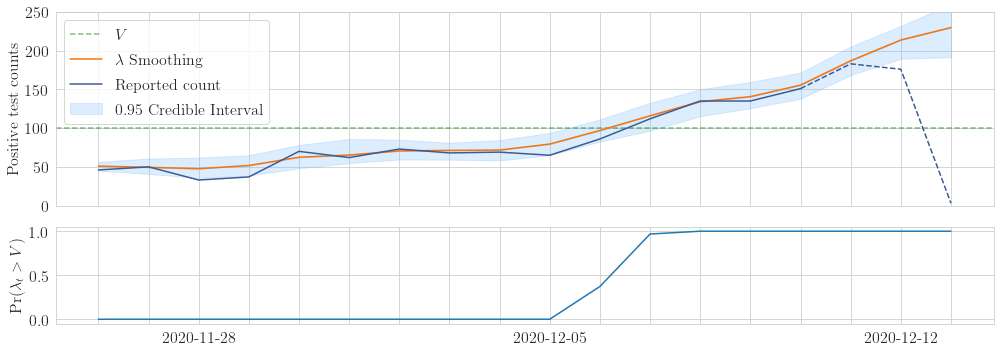

In [24]:
threshold = 100
alpha = 0.05

ltla = "Thurrock"

with open(f'results/2020-12-14/{ltla.replace(" ", "_")}.pickle', 'rb') as f:
        model = pickle.load(f)
        
start = 0        
        
obs = model._observations       
probs = [float(sum(lam>threshold))/len(lam) for lam in model.lambda_smoothing_samples][start:]

fig = plt.figure(figsize=(14,5))
gs = gridspec.GridSpec(2, 1,height_ratios=[2,1])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.axhline(threshold,alpha=0.5, label="$V$", color='green', linestyle="--")
plot_posterior(
    ax = ax1,
    obs=obs[start:],
    posterior_means = np.array([s.mean() for s in model.lambda_smoothing_samples ][start:]),
    posterior_confidence_intervals = np.array([empirical_credint(s, alpha) for s in model.lambda_smoothing_samples ][start:]),
    legend = False,
    posterior_label=r"$\lambda$ Smoothing",
    confidence_interval_label=f"{1-alpha} Credible Interval",
    obs_label="Reported count",
    alpha=0.25
)

sd_dates = pd.date_range(start="2020-11-26", end="2020-12-13").strftime("%Y-%m-%d")[start:]

ax1.legend(loc=2, fontsize=16)
ax1.set_ylim(0,250)

ax2.plot(sd_dates, probs)
ax2.set_ylim(-0.05,1.05)
ax2.set_ylabel(r"Pr($\lambda_t>V$)", fontsize=16)

ax1.set_ylabel("Positive test counts", fontsize=16)
ax1.set_xticks(np.arange(0,len(sd_dates)))
ax1.set_xticklabels([])

for ax in [ax1, ax2]:
    plt.setp(ax.get_yticklabels(), fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=16)
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=5))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    ax.grid(which='minor')

# plt.suptitle(f"{ltla}", fontsize=16)
plt.tight_layout()
plt.savefig(f"{ltla}_alert", dpi=500)

In [25]:
from models.utils import empirical_credint

kappa_smoothing_means = np.array(
    [s.mean() for s in model._drift_smoothing_samples]
)
kappa_smoothing_cis = np.array(
    [empirical_credint(s, 0.05) for s in model._drift_smoothing_samples]
)

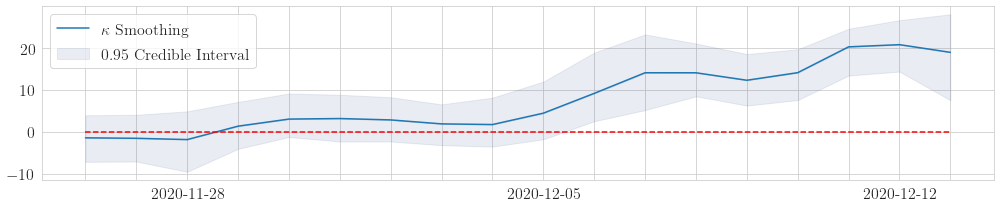

In [26]:
sd_dates = pd.date_range(start="2020-11-26", end="2020-12-13").strftime("%Y-%m-%d")[start:]

fig, ax = plt.subplots(1, 1, figsize=(14, 3))
ax.plot(sd_dates, kappa_smoothing_means, label=r'$\kappa$ Smoothing')
ax.plot([0,17], [0,0], 'r--')
# plt.title('Thurrock', fontsize=16)

upper, lower = (
    kappa_smoothing_cis[:, 0],
    kappa_smoothing_cis[:, 1],
)
ax.fill_between(
    sd_dates,
    kappa_smoothing_means,
    upper,
    alpha=0.11,
    color='xkcd:denim blue'
)
ax.fill_between(
    sd_dates, 
    kappa_smoothing_means, 
    lower, 
    alpha=0.11, 
    color='xkcd:denim blue',
    label='0.95 Credible Interval'
)
plt.legend(fontsize=16, loc=2)

plt.setp(ax.get_yticklabels(), fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=5))
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax.grid(which='minor')
plt.tight_layout()
plt.savefig(f"{ltla}_drift", dpi=500)

## Results plots

In [27]:
import os
from datetime import timedelta

In [28]:
from models.utils import empirical_credint

In [29]:
df = pd.read_csv(f"../data/cases-2020-12-30.csv")
all_ltlas = df.query("`Area type` == 'ltla'")['Area name'].unique()

In [30]:
def get_results(report_date, lags=5, results_path="results"):
    rd_datetime = pd.to_datetime(report_date)
    true_date = (rd_datetime + timedelta(7)).strftime("%Y-%m-%d")
    
    df_report = pd.read_csv(f'../data/cases-{report_date}.csv')
    df_report = df_report[(df_report['Area type']=='ltla')]
    df_report['Specimen date'] = pd.to_datetime(df_report['Specimen date'])
    df_report = df_report.sort_values("Specimen date")
    
    df = pd.read_csv(f'../data/cases-{true_date}.csv')
    df = df[(df['Area type']=='ltla')&(df['Specimen date']>='2020-10-09')&(df['Specimen date']<report_date)]
    df['Specimen date'] = pd.to_datetime(df['Specimen date'])
    df = df.sort_values("Specimen date")
       
    ma_errors = [[] for i in range(4)]
    baseline_ma_errors = [[] for i in range(4)]

    for ltla in all_ltlas:
        ltla_df = df[(df['Area name']==ltla)&(df['Specimen date']<report_date)]
        
        save_name = ltla.replace(" ", "_")
        path = f"{results_path}/{report_date}/{save_name}.pickle"
        model = pickle.load(open(path, 'rb'))
        evidence = sum(model.log_evidence)
        
        for lag in range(4):
            if lag == 0:
                true_ma_lag = ltla_df['Daily lab-confirmed cases'][-7:].mean()
                nowcast_ma_lag = np.mean([x.mean() for x in model.x_smoothing_samples[-7:]])  
            else:
                true_ma_lag = ltla_df['Daily lab-confirmed cases'][-7-lag:-lag].mean()
                nowcast_ma_lag = np.mean([x.mean() for x in model.x_smoothing_samples[-7-lag:-lag]])  
            ae_ma_lag = np.abs(nowcast_ma_lag - true_ma_lag)
            ma_errors[lag].append(ae_ma_lag)

            ### FOR BASELINE DROP LAST 4 DAYS AND JUST TAKES THE MOVING AVERAGE OF REPORTED DATA AT TIME OF MODEL AS THE NOW-CAST
            baseline_ma_lag = df_report[(df_report['Area name']==ltla)]['Daily lab-confirmed cases'][-11:-4].mean()      

            ae_baseline_ma_lag = np.abs(baseline_ma_lag - true_ma_lag)
            baseline_ma_errors[lag].append(ae_baseline_ma_lag)
                
    return ma_errors, baseline_ma_errors

In [31]:
def plot_ma_errors(ma_errors_1, ma_errors_2, title1, title2, save_name):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    pd.DataFrame(np.array(ma_errors_1).transpose(1,0)).boxplot(showfliers=False, whis=(5,95), ax=ax[0])
    pd.DataFrame(np.array(ma_errors_2).transpose(1,0)).boxplot(showfliers=False, whis=(5,95), ax=ax[1])

    for i in range(2):

        ax[i].set_xticklabels([1,2,3, 4])
        ax[i].set_xlabel("Lag", fontsize=16)
        plt.setp(ax[i].get_xticklabels(), fontsize=16)
        plt.setp(ax[i].get_yticklabels(), fontsize=16)

    ax[0].set_title(title1, fontsize=16)
    ax[1].set_title(title2, fontsize=16)

    ax[0].set_ylabel("Absolute error", fontsize=16)

    plt.suptitle("")
    plt.tight_layout()
    plt.savefig(f"ma_results_{save_name}", dpi=100)
    

In [32]:
ma_errors, baseline_ma_errors = get_results("2020-12-14")

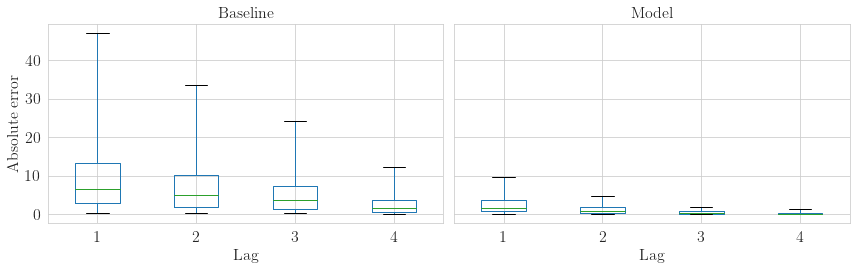

In [33]:
plot_ma_errors(baseline_ma_errors, ma_errors, "Baseline", "Model", "20201214")

## Weekend effect

In [34]:
import torch as t
import random

In [35]:
ltla = "Canterbury"

In [36]:
from models.inference import Nowcaster
from models.utils import empirical_credint
from models.plotting import plot_posterior

In [37]:
thin = 20
burn_in = 750
n_samples = 250

epsilon = 0.1

In [38]:
rd = pd.date_range(start="2020-11-20", end="2020-12-14")
sd = pd.date_range(start="2020-11-19", end="2020-12-13")

In [39]:
df = get_data(
    ltla,
    report_dates=rd,
    specimen_dates=sd,
)
ys_sequence = create_profiles(df)
alphas, betas = moment_match_theta_priors(df[df['Specimen date']>='2020-11-26'], n_lags=18)

x_0 = np.mean([ys[-1] for ys in ys_sequence[:7]])
prior_lam0_shape = 0.3 * x_0 ** 2. + (epsilon if x_0==0 else 0)
prior_lam0_rate = 0.3 * x_0 + (epsilon if x_0==0 else 0)

ys = np.array([ys[-1] for ys in ys_sequence[-18:]])

In [40]:
SEED = 7451
random.seed(SEED)
np.random.seed(SEED)
t.manual_seed(SEED)

model_weekend = Nowcaster(
        prior_lam0_shape=prior_lam0_shape,
        prior_lam0_rate=prior_lam0_rate,
        random_walk_scale=4,
        prior_theta_shape_a = alphas,
        prior_theta_shape_b = betas,
        sampler_length_scale=None
    )
model_weekend.marginal_filtering_drift(ys, sd[-18:], thin, burn_in, n_samples)
model_weekend.marginal_smoothing_drift()

In [41]:
SEED = 7451
random.seed(SEED)
np.random.seed(SEED)
t.manual_seed(SEED)

model_no_weekend = Nowcaster(
        prior_lam0_shape=prior_lam0_shape,
        prior_lam0_rate=prior_lam0_rate,
        random_walk_scale=4,
        prior_theta_shape_a = alphas,
        prior_theta_shape_b = betas,
        sampler_length_scale=None
    )
model_no_weekend.marginal_filtering_drift(ys, None, thin, burn_in, n_samples)
model_no_weekend.marginal_smoothing_drift()

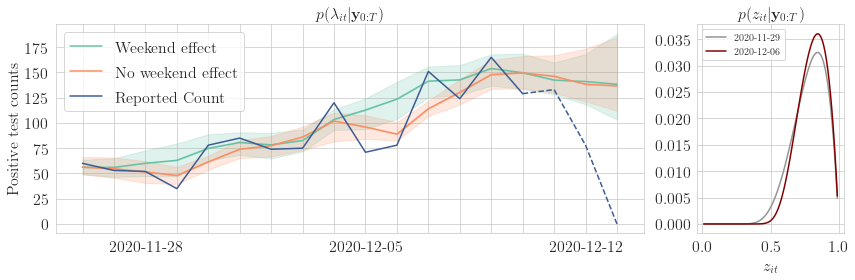

In [42]:
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[4,1])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

alpha=0.05
colors = sns.color_palette("Set2").as_hex()

for i, m in enumerate([model_weekend, model_no_weekend]):
    lambda_smoothing_means = np.array(
        [s.mean() for s in m.lambda_smoothing_samples]
    )
    lambda_smoothing_cis = np.array(
        [empirical_credint(s, alpha) for s in m.lambda_smoothing_samples]
    )
    if i == 0:
        plot_posterior(
            ax=ax1,
            posterior_color=colors[i],
            confidence_interval_color=colors[i],
            posterior_means=lambda_smoothing_means,
            posterior_confidence_intervals=lambda_smoothing_cis,
            posterior_label="Weekend effect",
        )
    else:
        plot_posterior(
            ax=ax1,
            obs=m._observations,
            title=r"$p(\lambda_{it} | \mathbf{y}_{0:T})$",
            posterior_color=colors[i],
            confidence_interval_color=colors[i],
            posterior_means=lambda_smoothing_means,
            posterior_confidence_intervals=lambda_smoothing_cis,
            posterior_label="No weekend effect",
            obs_label='Reported Count',
        ) 

    ax1.set_xticks(np.arange(0,len(m._observations)))
    ax1.set_xticklabels(sd[-18:].strftime("%Y-%m-%d"), rotation=360)
    
ax1.legend(loc=2, fontsize=16)
ax1.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=5))
ax1.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax1.grid(which='minor')
ax1.set_ylabel("Positive test counts", fontsize=16)

ax2.set_xlabel(r"$z_{it}$", fontsize=16)
ax2.set_title(r"$p(z_{it} | \mathbf{y}_{0:T})$", fontsize=16)

ax2.plot(model_weekend._weekend_corrections[1].values, model_weekend._weekend_corrections[1].log_probas.exp(), label='2020-11-29', color='xkcd:grey')
ax2.plot(model_weekend._weekend_corrections[3].values, model_weekend._weekend_corrections[3].log_probas.exp(), label='2020-12-06', color='xkcd:dark red')
ax2.legend()

for ax in [ax1, ax2]:
    plt.setp(ax.get_xticklabels(), fontsize=16)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    
plt.tight_layout()
plt.savefig(f"weekend_effect_december_{ltla}", dpi=100)

## Model selection

In [43]:
rd = pd.date_range(start="2020-11-10", end="2020-12-14")
sd = pd.date_range(start="2020-11-09", end="2020-12-13")

In [44]:
df = get_data(
    "Birmingham",
    report_dates=rd,
    specimen_dates=sd,
)
ys_sequence = create_profiles(df)
alphas, betas = moment_match_theta_priors(df[df['Specimen date']>='2020-11-26'], n_lags=28)

x_0 = ys_sequence[-28][-1]
prior_lam0_shape = 0.3 * x_0 ** 2. + (epsilon if x_0==0 else 0)
prior_lam0_rate = 0.3 * x_0 + (epsilon if x_0==0 else 0)

In [45]:
ys = np.array([ys[-1] for ys in ys_sequence[-28:]])

In [46]:
models = []

In [47]:
for sigma in [1., 2., 3., 4., 5.]:
    SEED = 3817
    random.seed(SEED)
    np.random.seed(SEED)
    t.manual_seed(SEED)

    model = Nowcaster(
            prior_lam0_shape=prior_lam0_shape,
            prior_lam0_rate=prior_lam0_rate,
            random_walk_scale=sigma,
            prior_theta_shape_a = alphas,
            prior_theta_shape_b = betas,
            sampler_length_scale=None
        )
    model.marginal_filtering_drift(ys, sd[-28:], thin, burn_in, n_samples)
    model.marginal_smoothing_drift()
    model.compute_evidence_drift()
    models.append(model)

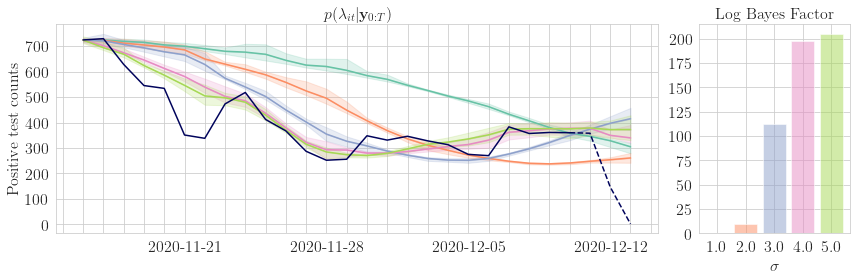

In [48]:
alpha=0.05

fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[4,1])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

colors =  sns.color_palette("Set2").as_hex()
ev = []
sigmas = []

comp_ev = sum(models[0].log_evidence)

for i, m in enumerate(models):
    sigmas.append(m._random_walk_scale)
    lambda_smoothing_means = np.array(
        [s.mean() for s in m.lambda_smoothing_samples]
    )
    lambda_smoothing_cis = np.array(
        [empirical_credint(s, alpha) for s in m.lambda_smoothing_samples]
    )
    plot_posterior(
        ax=ax1,
        title=r"$p(\lambda_{it} | \mathbf{y}_{0:T})$",
        posterior_color=colors[i],
        confidence_interval_color=colors[i],
        posterior_means=lambda_smoothing_means,
        posterior_confidence_intervals=lambda_smoothing_cis,
        posterior_label=r"$\lambda$ Smoothing",
        confidence_interval_label=f"{1-alpha} Credible Interval",
    )

    ax1.set_xticks(np.arange(0,len(m._observations)))
    ax1.set_xticklabels(sd[-28:].strftime("%Y-%m-%d"), rotation=360)
    ev.append(sum(m.log_evidence)-comp_ev)
    
support = np.arange(len(lambda_smoothing_means)) 
ax1.plot(support[:-3], m._observations[:-3], color="xkcd:dark blue")
ax1.plot(support[-4:], m._observations[-4:], "--", color="xkcd:dark blue")

ax2.bar(np.arange(len(sigmas)), ev, color=colors, tick_label=sigmas, alpha=0.5)
ax2.set_title("Log Bayes Factor", fontsize=16)
ax2.set_xlabel(r"$\sigma$", fontsize=16)

ax1.set_ylabel("Positive test counts", fontsize=16)
ax1.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=1))
ax1.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
ax1.grid(which='minor')

for ax in [ax1, ax2]:
    plt.setp(ax.get_xticklabels(), fontsize=16)
    plt.setp(ax.get_yticklabels(), fontsize=16)

plt.tight_layout()
plt.savefig(f"Birmingham_sigmas", dpi=100)
plt.show()